In [36]:
import numpy as np
import numpy.linalg as npl
import scipy.linalg as spl
import sklearn.metrics as sklm
import math
import matplotlib.pyplot as plt
import pandas as pd #to help see arrays clearly when debugging 
plt.rcParams['figure.figsize'] = [8, 8]
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# 18.1,2 Nonlinear Equations and Least Squares, Gauss-Newton Algorithm

"**Basic Gauss-Newton Algorithm.** Let's first implement the basic Gauss-Newton method (algorithm 18.1 in VMLS) in Julia. In Julia you can pass a function as an argument to another function ,so we can pass f (the function) and also Df (the derivative or Jacobian matrix) to our Gauss-Newton algorithm."

```python
def gauss_newton(f, Df, x1, kmax = 10):
    x = x1
    for k in range(kmax):
        x = x - npl.lstsq(Df(x),f(x))
    return x
```

"Here we simply run the algorithm for a fixed number of iterations kmax, specified by an optional keyword argument with default value 10. The code does not verify whether the final x is actually a solution, and it will break down when $Df(x^{(k)})$ has linearly dependent columns. This very simple implementation is only for illustrative purposes; the Levenberg-Marquardt algorithm described in the next section is better in every way."

"**Newton Algorithm.** The Gauss-Newton algorithm reduces to the Newton algorithm when. the function mapps n-vectors to n-vectors, so the function above is also an implementation of the Newton method for solving nonlinear equations. The only difference with the following funciton is the stopping condition. In Newton's method one terminates when $||f(x^{k})||$ is sufficiently small."

In [104]:
def newton(f,Df, x1, kmax=20, tol = 1e-6):
    x = x1
    fnorms = [] 
    for k in range(kmax):
        fk = f(x)
        fnorms.append(npl.norm(fk))
        if npl.norm(fk) < tol:
            break
        x = x - npl.lstsq(np.vstack([0,Df(x)]),np.vstack([0,fk]))[0]
        #using vstacks to make lstsq work on single values
    return x, np.vstack(fnorms)

"We added a second optional argument with the tolerance in the stopping condition on line 7. The default value is $10^{-6}$. We also added a second output argument ```fnorms```, with the sequence $f(x^{(k)}||$, so we can examine the covnergencei n the following examples. 

**Newton algorithm for n = 1.** Our first example is a scalar nonlinear equation f(x) = 0 with

$$f(x) = \dfrac{e^{x} - e^{-x}}{e^{x} + e^{-x}}$$

(VMLS figures 18.3 and 18.4)."

In [128]:
f = lambda x: (np.exp(x) - np.exp(-x))/(np.exp(x)+np.exp(-x))

In [129]:
Df = lambda x: 4 / (np.exp(x) + np.exp(-x))**2

"We first try with $x^{(1)}$ = 0.95."

In [107]:
x, fnorms = newton(f,Df,.95)
x
fnorms

/Users/vb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if __name__ == '__main__':


array([[4.34519743e-07]])

array([[7.39783051e-01],
       [5.94166364e-01],
       [2.30111246e-01],
       [8.67002865e-03],
       [4.34519743e-07]])

Text(0.5, 1.0, 'Figure 18.1 The first iterations in the Newton algorithm for solving $f(x) = 0$ for starting point $x^{(1)} = 0.95$.')

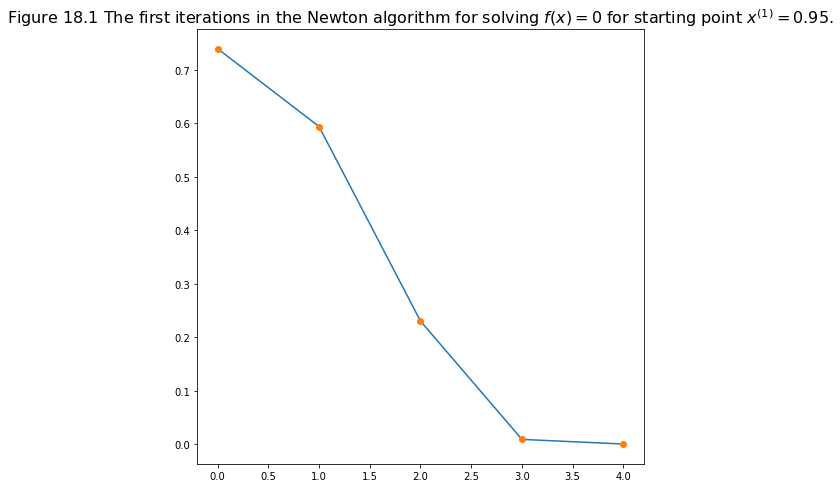

In [120]:
plt.plot(fnorms)
plt.plot(fnorms, "o")
plt.title("Figure 18.1 The first iterations in the Newton algorithm for solving $f(x) = 0$ for starting point $x^{(1)} = 0.95$.", fontsize=16)

"The method converges very quickly, as can also be seen in figure 18.1. However it does not converge for a slightly larger starting point $x^{(1)} = 1.15$."

/Users/vb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if __name__ == '__main__':
/Users/vb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in exp
  """Entry point for launching an IPython kernel.
/Users/vb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


array([[nan]])

array([[0.81775408],
       [0.86640565],
       [0.97355685],
       [1.        ],
       [       nan]])

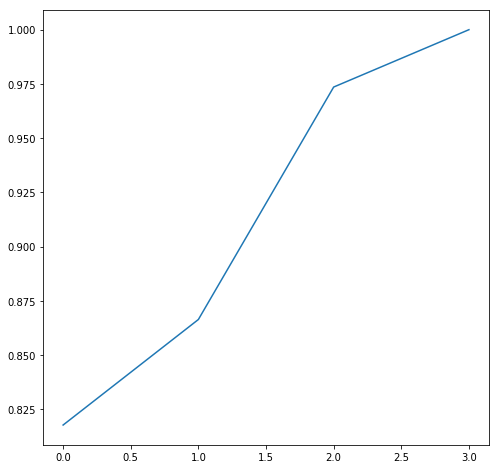

In [126]:
x, fnorms = newton(f,Df, 1.15)
f(x)
fnorms[:5]
plt.plot(fnorms)

# 18.3 Levenberg-Mardquardt Algorithm

"The Gauss-Newton algorthim can fail if the derviative matrix does not have independent columns. It also does not guarantee that $||f(x^{(k)})||$ decreases in each iteration. Both of these shortcomings are addressed in the Levenberg-Marquardt algorithm. Below is a Julia implementation of algorithm 18.3 in VMLS. This function is included in the Vmls package.*"

*SciPy implementation: https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html

In [544]:
def levenberg_marquardt(f, Df, x1, lambda1, kmax = 100, tol = 1e-6):
    n = len(x1)
    x = x1
    lambd = lambda1
    objectives = [] 
    residuals = []
    for k in range(kmax):
        fk = f(x)
        Dfk = Df(x)
        objectives.append(npl.norm(fk)**2)
        residuals.append(npl.norm(2*np.matmul(Dfk.T,fk)))
        if npl.norm(2*np.matmul(Dfk.T,fk)) < tol:
            break
        xt = x - npl.lstsq(np.vstack([Dfk,np.sqrt(lambd)*np.eye(n)]),np.vstack([fk,np.zeros((n,1))]))[0]
        if npl.norm(f(xt)) < npl.norm(fk):
            lambd = .8*lambd
            x = xt
        else:
            lambd = 2.0*lambd
    return x, dict([("objectives", objectives),("residuals",residuals)])

"Line 12 is the second stopping criterion suggested on page 393 of VMLS, and checks whether the optimality condition (18.3) is approximately satisfied. The default tolerance $10^{-6}$ can vary with the scale of the problem and the desired accuracy. Keep in midn that the otpimality condition (18.3) is a necessary condition and does not guarantee that the solution minimizes the nonlinear least squares objective $||f(x)||^{2}$. The code limits the number of iterations to $k^{max}$, after which it is assumed that the algorithm is failing to converge. 

The function returns a dictionary with information about the sequence of iterates, including the value of $||f(x^{(k)}||^{2}$ and $||Df(x^{(k)})^{T}f(x^{(k)}|||$ at each iteration.

**Nonlinear equation.** We apply the algorithm to the scalar function (18.1) with the starting point $x^{(1)} = 1.15$."

/Users/vb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  from ipykernel import kernelapp as app


Text(0.5, 0, 'k')

Text(0, 0.5, '$|f|$')

Text(0.5, 1.0, 'Figure 18.2 Values of $|f(x^{(k)})|$ versus the iteration number $k$ for the \n Levenberg-Marquardt algorithm applied to $f(x) = \\dfrac{(exp(x) - exp(-x))}{(exp(x)+exp(-x))}$. \n The starting point is $x^{(1)} = 1.15 and \\lambda^{(1)} = 1$.')

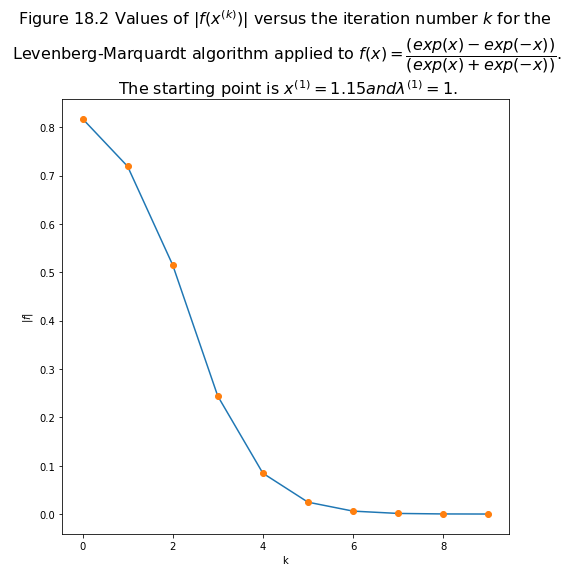

In [325]:
f = lambda x: (np.exp(x) - np.exp(-x))/(np.exp(x)+np.exp(-x))
Df = lambda x: 4 / (np.exp(x) + np.exp(-x))**2
x,history = levenberg_marquardt(f,Df,np.array([1.15]), 1.0)
plt.plot(np.sqrt(history["objectives"][:10]))
plt.plot(np.sqrt(history["objectives"][:10]), "o")
plt.xlabel("k")
plt.ylabel("$|f|$")
plt.title("Figure 18.2 Values of $|f(x^{(k)})|$ versus the iteration number $k$ for the \n Levenberg-Marquardt algorithm applied to $f(x) = \dfrac{(exp(x) - exp(-x))}{(exp(x)+exp(-x))}$. \n The starting point is $x^{(1)} = 1.15 and \lambda^{(1)} = 1$.", fontsize=16)

"The result is shown in figure 18.2. 

Note that we defined $x^{(1)}$ as the array [1.15], and use dot-operations in the definitions of ```f``` and ```Df``` to ensure that these functions work with vector arguments. This is important because Julia distinguishes between scalars and 1-vectors. If we call the ```levenberg_marquardt``` function with a scalar argument ```x1```, line 15 will raise and error, because Julia does not accept subtractions of scalars and 1-vectors.

**Equilibrium prices.** We solve a nonlinear equation $f(p) = 0$ with two variables, where 

$$f(p) = exp(E^{s}log p + s^{nom}) - exp(E^{d}log p + d^{nom}).$$ (18.2)

Here exp and log are interpreted as element-wise vector operations. The problem parameters are $s^{nom} = (2.2,0.3), d^{nom}=(3.1,2.2),$

\begin{equation}
E^{s} = 
\begin{bmatrix}
   .5 & -0.3 & \\
    -0.15 & 0.8 
\end{bmatrix}, 
E^{d} = 
\begin{bmatrix}
   .5 & 0.2 & \\
    0 & -0.5 
\end{bmatrix}
\end{equation}

/Users/vb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  app.launch_new_instance()


array([[5.64410853],
       [5.26575493]])

Text(0.5, 1.0, 'Figure 18.3 Cost function $||f(p^{(k)}||^2$ versus iteration number k \n for the example of equation (18.2).')

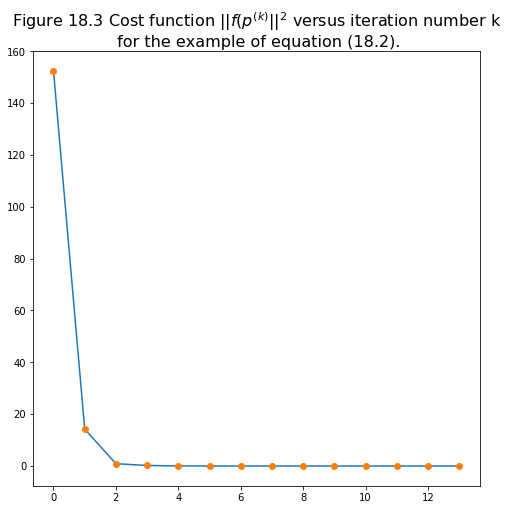

In [356]:
snom, dnom = np.array([2.2,0.3]),np.array([3.1,2.2])
Es,Ed = np.vstack([[0.5,-.3],[-.15,.8]]),np.vstack([[-.5,.2],[-0.0,-0.5]])
f = lambda p: np.vstack(np.exp(np.matmul(Es , np.log(p.ravel())) + snom) - np.exp(np.matmul(Ed , np.log(p.ravel())) + dnom))
def Df(p):
    p = p.ravel()
    S = np.exp(np.matmul(Es , np.log(p)) + snom)
    D = np.exp(np.matmul(Ed , np.log(p)) + dnom)
    a = np.vstack([np.hstack([S[0]*Es[0,0]/p[0], S[0]*Es[0,1]/p[1]]),np.hstack([S[1]*Es[1,0]/p[0], S[1]*Es[1,1]/p[1]])])
    b = np.vstack([np.hstack([D[0]*Ed[0,0]/p[0], D[0]*Ed[0,1]/p[1]]),np.hstack([D[1]*Ed[1,0]/p[0], D[1]*Ed[1,1]/p[1]])])
    return a-b
p,history = levenberg_marquardt(f,Df, np.vstack([3,9]), 1)
p
plt.plot(history["objectives"])
plt.plot(history["objectives"], "o")
plt.title("Figure 18.3 Cost function $||f(p^{(k)}||^2$ versus iteration number k \n for the example of equation (18.2).", fontsize=16)

Figure 18.3 shows the plot of $||f(p^{(k)})||^2$ versus iteration number k.

"The expression for the derivative is 

\begin{equation}
Df(x) = 
\begin{bmatrix}
   \frac{x_1 - (a_{1})_{1}}{||x - a_1||} & \frac{x_2 - (a_{1})_{2}}{||x - a_1||} & \\
    \vdots & \vdots \\
    \frac{x_1 - (a_{m})_{1}}{||x - a_m||} & \frac{x_2 - (a_{m})_{2}}{||x - a_m||}
\end{bmatrix}
.
\end{equation}

This can be evaluated as the product of a diagonal matrix with diagonal entries $\frac{1}{||x-a_i||}$ and the $5 x 2$ matrix with $i,j$ entry $(x - a_i)_j$.

We run the Levenberg-Marquardt method for three starting points and $\lambda^{(1)} = 0.1.$ The plot is shown in figure 18.4.

In [424]:
#"Five locations ai in a 5x2 matrix.
A = np.vstack([[1.8,2.5],[2.0,1.7],[1.5,1.5],[1.5,2.0],[2.5, 1.5]])
#Vector of measured distances to five locations.
rhos = np.vstack([1.87288, 1.23950, .53672, 1.29273, 1.49353])
#dist(x) returns a 5-vector with the distances ||x-ai||.
dist = lambda x: np.vstack(np.sqrt((x[0] - A[:,0])**2 + (x[1] - A[:,1])**2))
#f(x) returns the five residuals
f = lambda x: dist(x) - rhos
#Df(x) is the 5x2 derivative.
Df = lambda x: np.matmul(np.diag(1/dist(x).T[0]) , np.array([(x[0] - A[:,0]), (x[1] - A[:,1])]).T)
#Solve with starting point (1.8,3.5) and lambda = 0.1.
x1, history1 = levenberg_marquardt(f,Df,np.vstack([1.8,3.5]),.1)
x1
x2, history2 = levenberg_marquardt(f,Df,np.vstack([3.0,1.5]),.1)
x2
x3, history3 = levenberg_marquardt(f,Df,np.vstack([2.2,3.5]),.1)
x3

/Users/vb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  app.launch_new_instance()


array([[1.18248598],
       [0.82422894]])

array([[1.18248579],
       [0.82422895]])

array([[2.98526641],
       [2.1215768 ]])

Text(0.5, 1.0, 'Figure 18.4 Cost function $||f(x^{(k)})||^2$ versus iteration number $k$ for the\n three starting points in the location from range measurements example.')

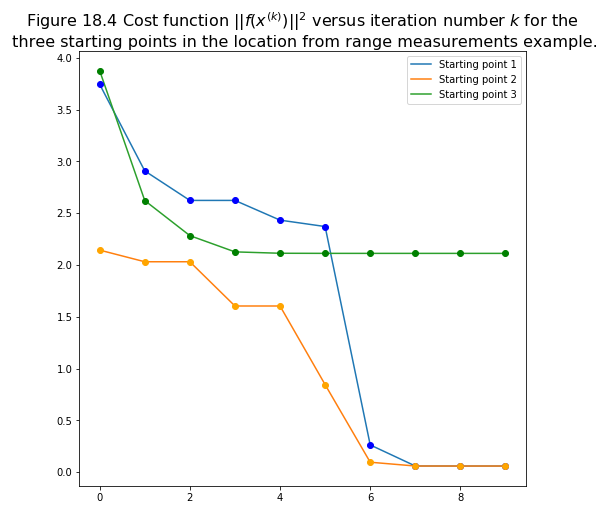

In [432]:
plt.plot(history1["objectives"][:10])
plt.plot(history2["objectives"][:10])
plt.plot(history3["objectives"][:10])
plt.legend(["Starting point 1", "Starting point 2", "Starting point 3"])
plt.plot(history1["objectives"][:10], "o", color="blue")
plt.plot(history2["objectives"][:10], "o", color="orange")
plt.plot(history3["objectives"][:10], "o", color="green")
plt.title("Figure 18.4 Cost function $||f(x^{(k)})||^2$ versus iteration number $k$ for the\n three starting points in the location from range measurements example.", fontsize = 16)

# 18.4 Nonlinear model fitting

"**Example.** We fit a model

$$ \hat{f}(x;\theta) = \theta_1e^{\theta_2x}cos(\theta_3x + \theta_4)$$

to $N = 60$ data points. We first generate the data.
"

In [538]:
#"Use these parameters to generate data."
theta_ex = np.vstack([1,-.2,1*np.pi/5, np.pi/3])
M=30
xd = np.vstack(np.array([5*np.random.rand(M),
                5 + 15*np.random.rand(M)]).ravel())
yd = np.vstack(theta_ex[0] * np.exp(theta_ex[1]*xd) * np.cos(theta_ex[2] * xd + theta_ex[3]))
N = len(xd.ravel())

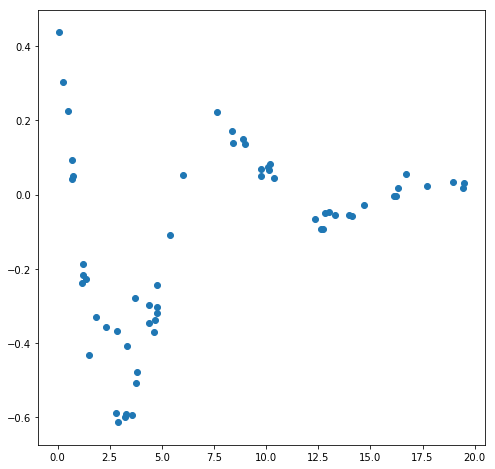

In [539]:
yd = np.vstack(yd.ravel()) * np.vstack((1 + .2*np.random.randn(N)))+.015 * np.vstack(np.random.randn(N))

"The 60 points are shown in figure 18.5. We now run our Levenberg-Marquardt code with starting point $\theta^{(1)} = (1,0,1,0)$ and $\lambda^{(1)} = 1$. The fitted model is shown in figure 18.5."

In [548]:
theta1 = np.vstack([1,0,1,0])

In [549]:
f = lambda theta: theta[0] * np.exp(theta[1]*xd) * np.cos(theta[2] * xd + theta[3]) - yd

In [550]:
Df = lambda theta: np.hstack([
    np.exp(theta[1]*xd) * np.cos(theta[2] * xd + theta[3]), 
    theta[0] * (xd * np.exp(theta[1] * xd) * np.cos(theta[2] * xd + theta[3])),
    -theta[0] * (np.exp(theta[1] * xd) * xd * np.sin(theta[2] * xd + theta[3])),
    -theta[0] * (np.exp(theta[1]*xd) * np.sin(theta[2] * xd + theta[3]))
])

In [551]:
theta, history = levenberg_marquardt(f, Df, theta1, 1.0)
theta

/Users/vb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


array([[ 1.00941898],
       [-0.20369987],
       [ 0.61141687],
       [ 1.06475081]])

Text(0.5, 0.98, 'Figure 18.5 Least squares fit of a function to $N=60$ points $(x^{(i)}, y^{(i)})$.')

Text(0.5, 1.0, '$\\hatf(x;\\theta) = \\theta_1e^{\\theta_2x}cos(\\theta_3x+\\theta_4)$')

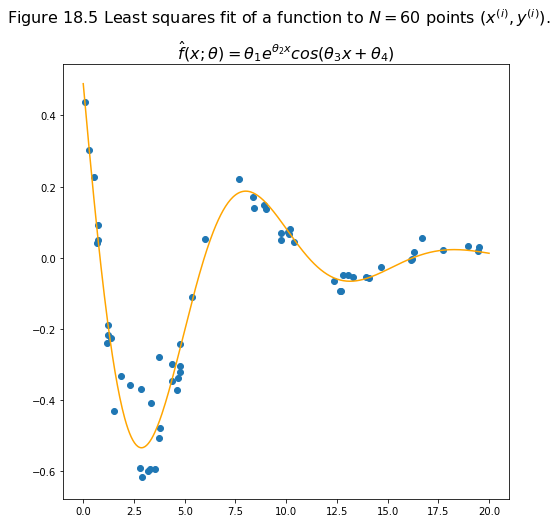

In [585]:
x = np.linspace(0,20,500)
y = theta[0] * np.exp(theta[1]*x) * np.cos(theta[2]*x + theta[3])
plt.scatter(xd,yd)
plt.plot(x,y, "orange")
plt.suptitle(r"Figure 18.5 Least squares fit of a function to $N=60$ points $(x^{(i)}, y^{(i)})$.", fontsize=16)
plt.title(r"$\hatf(x;\theta) = \theta_1e^{\theta_2x}cos(\theta_3x+\theta_4)$", fontsize=16)

**Orthogonal distance regression.** In figure 18.14 of VMLS we use orthogonal distance regression to fit a cubic polynomial

$$\hat{f}(x,\theta = \theta_1 + \theta_2x + \theta_3x^2 + \theta_4x^3$$

to $N = 25$ data points. 

We first read in the data and compute the standard least squares fit."

In [609]:
xd,yd = np.vstack([0.86386309, 0.90618764, 0.20014826, 0.85939524, 0.79595557,
       0.33819773, 0.72932294, 0.54275044, 0.43020086, 0.39633836,
       0.21374603, 0.13375768, 0.88272295, 0.81474823, 0.74534507,
       0.97604522, 0.12427354, 0.63125497, 0.93099425, 0.86551811,
       0.50123228, 0.50469551, 0.98376456, 0.84229176, 0.45119254]), np.vstack([ 0.27611492,  0.14607854, -0.17249809,  0.12608163,  0.21116035,
       -0.17649459,  0.23701947,  0.11231777, -0.19117909, -0.13786833,
       -0.08796589, -0.14053485,  0.22141246,  0.27933879,  0.26250175,
       -0.06684589, -0.03550143,  0.20836081,  0.05571696,  0.1038155 ,
        0.04986653,  0.04660768,  0.0068115 ,  0.25800022, -0.09535889])

In [611]:
N = len(xd)
p = 4
theta_ls = npl.lstsq(np.flip(np.vander(xd.ravel(),p),1), yd)[0]
theta_ls

/Users/vb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  This is separate from the ipykernel package so we can avoid doing imports until


array([[ 0.3275608 ],
       [-4.39266679],
       [11.04691736],
       [-7.09439641]])

"The nonlinear least squares formulation on page 400 of VMLS has $p + N$ variables $\theta_1,...,\theta_p, u^{(1)}, ..., u^{(N)}$. We will store them in that order in the nonlinear least squares vector variable. The objective is to minimize the squared norm of the $2N$-vector

\begin{bmatrix}
   \hat{f}(u^{(1)}; \theta) - y^{(1)} \\
    \vdots \\
    \hat{f}(u^{(N)}; \theta) - y^{(N)} \\
    u^{(1)} - x^{(1)} \\
    \vdots \\
    u^{(N)} - x^{(N)}
\end{bmatrix}


In [644]:
def f(x):
    theta = x[:p]
    u = x[p:]
    f1 = np.matmul(np.flip(np.vander(u.ravel(),p),1), theta) - yd
    f2 = u - xd
    return np.vstack([f1,f2])

In [669]:
def Df(x):
    theta = x[:p]
    u = x[p:]
    D11 = np.flip(np.vander(u.ravel(),p),1)
    D12 = np.diag(theta[1] + 2*theta[2]*u.T[0] + 3*theta[3]*u.T[0]**2)
    D21 = np.zeros((N,p))
    D22 = np.eye(N)
    return np.vstack([(np.hstack([D11,D12])),np.hstack([D21,D22])])

We now call `levenberg-marquardt` with these two functions. A natural choice for the initial point is to use the least squares solution for the variables $\theta$ and the data points $x^{(i)}$ for the variables $u^{(i)}$. We use $\lambda^{(1)} = 0.01$.

In [670]:
sol, hist = levenberg_marquardt(f,Df, np.vstack([theta_ls,xd]), .01)
theta_od = sol[:p]

/Users/vb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


"Figure 18.6 shows the two fitted polynomials."

Text(0.5, 1.0, 'Figure 18.6 Least squares and orthogonal distance regression \n fit of a cubic polynomial to 25 data points.')

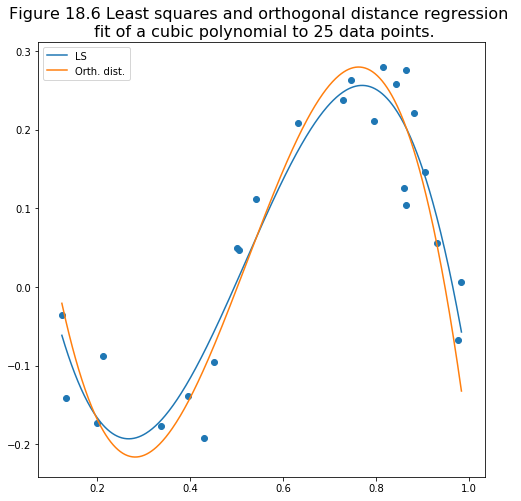

In [684]:
plt.scatter(xd,yd)
x = np.linspace(min(xd),max(xd),500)
y_ls = np.matmul(np.flip(np.vander(x.ravel(),p),1) , theta_ls)
y_od = np.matmul(np.flip(np.vander(x.ravel(),p),1), theta_od)
plt.plot(x,y_ls)
plt.plot(x,y_od)
plt.legend(["LS","Orth. dist."])
plt.title("Figure 18.6 Least squares and orthogonal distance regression \n fit of a cubic polynomial to 25 data points.", fontsize=16)

# 18.5 Nonlinear Least Squares Classification